# Deep Learning
## Transformer for Film Genre Classification

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#### The Movies Dataset

This project makes use of the [Kaggle Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). This dataset consists of metadata for all 45,000 movies listed in the Full MovieLens Dataset.

In [ ]:
movies_metadata = pd.read_csv(os.path.join('data', 'movies_metadata.csv'))
movies_metadata.shape

In [3]:
movies_metadata.sample(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
9067,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 9648,...",NaN,30718,tt0113617,en,Last of the Dogmen,A Montana bounty hunter is sent into the wilde...,...,1995-09-08,0.0,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A journey of the heart. The adventure of their...,Last of the Dogmen,False,7.2,34.0
4547,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,22102,tt0098519,en,Troop Beverly Hills,A Beverly Hills housewife in the middle of a d...,...,1989-03-22,0.0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"When the going gets tough, the tough go shopping!",Troop Beverly Hills,False,5.6,57.0
13834,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",http://www.homethemovie.org/,62320,tt1014762,fr,Home,"With aerial footage from 54 countries, Home is...",...,2009-06-03,0.0,95.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,A Stunning Visual Portrayal of Earth,Home,False,7.9,181.0
8126,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,104659,tt0081528,en,A Small Circle of Friends,"In the late 1960s, three Harvard students Jess...",...,1980-03-12,0.0,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The story of three people and the era that sha...,A Small Circle of Friends,False,6.0,1.0
45182,False,NaN,0,"[{'id': 53, 'name': 'Thriller'}]",NaN,15525,tt0288861,nl,Van God Los,Two small town Dutch boys whose socially unnat...,...,2003-04-24,0.0,90.0,"[{'iso_639_1': 'nl', 'name': 'Nederlands'}]",Released,Rock Hard and In Your Face,Godforsaken!,False,5.9,10.0


### 1) Data Cleaning and Preprocessing

In [4]:
# The following helper function will parse a single cell in the 'genres' column to return a python list

import json

def parse_genres(cell_text):
    return json.loads(cell_text.replace("'", '"'))

In [5]:
# Parse 'genres' and pick out the name values as a list and 
df = movies_metadata.loc[:,['genres','overview']]
df['genres'] = df['genres'].apply(parse_genres).apply(lambda z: list(map(lambda x: x['name'], z)))

print(df.shape)

df = df.dropna(subset=['overview'])

print(df.shape)

df.head()

(45466, 2)
(44512, 2)


,genres,overview
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...
2,"[Romance, Comedy]",A family wedding reignites the ancient feud be...
3,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom..."
4,[Comedy],Just when George Banks has recovered from his ...


In [6]:
# many overview descriptions are uninformative or missing.
df.overview.iloc[np.where(df.overview.map(lambda x: len(x))<20)]

104      No overview found.
722           German Comedy
800      No overview found.
972      No overview found.
1613     No overview found.
                ...        
44607    No overview found.
45251    No overview found.
45272    No overview found.
45292    No overview found.
45433    No overview found.
Name: overview, Length: 189, dtype: object

In [18]:
# filter out rare genres and useless uninformative descriptions then drop missing values 
rare_genres = df.genres.explode().value_counts()\
                [df.genres.explode().value_counts()==1].index.values
print(f"rare_genres={rare_genres}")

df['genres'] = df['genres'].apply(lambda x: [genre for genre in x if genre not in rare_genres])
df['genres'] = df['genres'].apply(lambda x: x if len(x) > 0 else np.NAN)
df['overview'] = df['overview'].map(lambda x: x if len(x) >= 50 else np.NAN) 

# filter out these 
df = df.dropna()
df = df.reset_index().drop('index', axis=1)

print(f"df.shape={df.shape}")


rare_genres=['Carousel Productions' 'Vision View Entertainment'
 'Telescene Film Group Productions' 'Aniplex' 'GoHands' 'BROSTA TV'
 'Mardock Scramble Production Committee' 'Sentai Filmworks'
 'Odyssey Media' 'Pulser Productions' 'Rogue State' 'The Cartel']
df.shape=(41928, 2)


In [19]:
# One-hot encode the multiple labels.
from sklearn.preprocessing import MultiLabelBinarizer
y_label_encoder = MultiLabelBinarizer()
y = y_label_encoder.fit_transform(df.genres).astype(np.float32)
X = df.overview

print(X, y, sep='\n\n')

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
41923    A film archivist revisits the story of Rustin ...
41924    It's the year 3000 AD. The world's most danger...
41925    Yet another version of the classic epic, with ...
41926    An artist struggles to finish his work while a...
41927    When one of her hits goes wrong, a professiona...
Name: overview, Length: 41928, dtype: object

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]


In [20]:
# double check the descriptions and labels make sense 
#  (looks like Toy Story and Apocalypse Now?)

print(X[0], y_label_encoder.classes_[np.where(y[0])], '\n', sep='\n')
print(X[1111], y_label_encoder.classes_[np.where(y[1111])], sep='\n')

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
['Animation' 'Comedy' 'Family']


At the height of the Vietnam war, Captain Benjamin Willard is sent on a dangerous mission that, officially, "does not exist, nor will it ever exist." His goal is to locate - and eliminate - a mysterious Green Beret Colonel named Walter Kurtz, who has been leading his personal army on illegal guerrilla missions into enemy territory.
['Drama' 'War']


In [21]:
# train/test/validation splits. Note the reduced number of observations is now divisible by 6.
#  So we partition  4/6 = 66.6% Training Data,  1/6 = 16.6% Validation data,  1/6 = 16.6% Test Data.
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=1/6, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/5, random_state=0)

In [22]:
# shapes of arrays
print(f' y_train: {y_train.shape}, \n y_val: {y_val.shape}, \n y_test: {y_test.shape}, \n X_train: {X_train.shape}, \n X_val: {X_val.shape}, \n X_test: {X_test.shape}')

 y_train: (27952, 20), 
 y_val: (6988, 20), 
 y_test: (6988, 20), 
 X_train: (27952,), 
 X_val: (6988,), 
 X_test: (6988,)


Drama              19899
Comedy             12656
Thriller            7548
Romance             6641
Action              6531
Horror              4626
Crime               4251
Documentary         3826
Adventure           3458
Science Fiction     3008
Family              2712
Mystery             2445
Fantasy             2275
Animation           1896
Foreign             1579
Music               1566
History             1375
War                 1307
Western             1027
TV Movie             745
Name: genres, dtype: int64


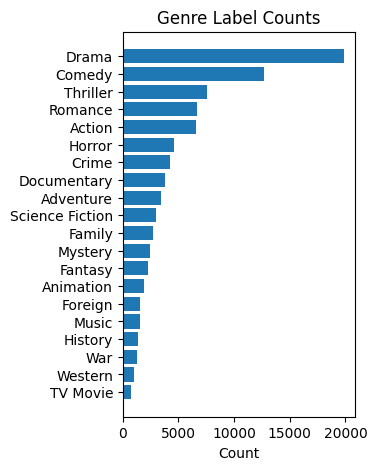

In [23]:
# printing and visualising the 20 genres that will be used:
genre_value_counts = df.genres.explode().value_counts()
print(genre_value_counts)

desc_genre_counts = genre_value_counts.sort_values(ascending=True)

plt.figure(figsize=(3, 5))
plt.barh(y=desc_genre_counts.index, width=desc_genre_counts)
plt.title('Genre Label Counts', size=12)
plt.xlabel('Count')
plt.show()

# We notice a substantial class imbalance, where the most popular genre of 'Drama'
#   has more than 25x as many observations as the least popular genre of 'TV Movie'

In [24]:
# genre correlation matrix 
correl_mat = pd.DataFrame(y).corr().rename(index=dict(enumerate(y_label_encoder.classes_)),
                                           columns=dict(enumerate(y_label_encoder.classes_)))
correl_mat

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Action,1.000000,0.282209,0.010340,-0.093181,0.151837,-0.128121,-0.104789,-0.038623,0.040830,0.035945,0.012490,-0.050083,-0.072122,-0.038128,-0.108344,0.152268,-0.020435,0.201358,0.047463,0.086384
Adventure,0.282209,1.000000,0.137124,-0.040758,-0.032631,-0.081156,-0.105247,0.195751,0.188066,-0.032439,0.026092,-0.063795,-0.042138,-0.029470,-0.056212,0.120586,-0.007510,-0.015462,0.019560,0.031577
Animation,0.010340,0.137124,1.000000,-0.006578,-0.062834,-0.058201,-0.157879,0.336634,0.148526,-0.027978,-0.031050,-0.055024,-0.002309,-0.030155,-0.072405,0.066708,-0.009287,-0.086138,-0.028469,-0.029287
Comedy,-0.093181,-0.040758,-0.006578,1.000000,-0.072150,-0.180759,-0.198675,0.074011,0.008323,-0.026915,-0.098906,-0.126753,0.024194,-0.098001,0.151893,-0.071868,-0.022762,-0.222632,-0.084164,-0.053441
Crime,0.151837,-0.032631,-0.062834,-0.072150,1.000000,-0.091897,0.076662,-0.076446,-0.067899,-0.018716,-0.035231,-0.056247,-0.049911,0.151435,-0.076032,-0.069498,-0.005702,0.255374,-0.053432,-0.034824
Documentary,-0.128121,-0.081156,-0.058201,-0.180759,-0.091897,1.000000,-0.266177,-0.066496,-0.072977,0.007358,0.025823,-0.104455,0.080850,-0.073554,-0.131345,-0.081676,-0.015662,-0.142873,-0.019190,-0.048070
Drama,-0.104789,-0.105247,-0.157879,-0.198675,0.076662,-0.266177,1.000000,-0.091095,-0.084488,0.048323,0.109532,-0.209539,-0.032046,0.001958,0.167994,-0.151138,0.010638,-0.021541,0.098309,-0.066869
Family,-0.038623,0.195751,0.336634,0.074011,-0.076446,-0.066496,-0.091095,1.000000,0.192559,-0.030120,-0.038078,-0.085799,0.018772,-0.045165,-0.042110,0.011061,0.060783,-0.112871,-0.041591,-0.027870
Fantasy,0.040830,0.188066,0.148526,0.008323,-0.067899,-0.072977,-0.084488,0.192559,1.000000,-0.023602,-0.037603,0.038644,-0.004981,0.000151,-0.010767,0.143526,0.009226,-0.048930,-0.033271,-0.031825
Foreign,0.035945,-0.032439,-0.027978,-0.026915,-0.018716,0.007358,0.048323,-0.030120,-0.023602,1.000000,-0.007585,-0.014081,-0.020466,-0.015546,0.029819,-0.020526,-0.024710,-0.003344,-0.014578,-0.025673


In [25]:
# printing each genre and it's most 3 highly correlated co-genres.
for genre in correl_mat:
    print(genre, correl_mat[genre].sort_values(ascending=False)[1:4], '\n', sep='\n')

Action
Adventure          0.282209
Thriller           0.201358
Science Fiction    0.152268
Name: Action, dtype: float64


Adventure
Action     0.282209
Family     0.195751
Fantasy    0.188066
Name: Adventure, dtype: float64


Animation
Family       0.336634
Fantasy      0.148526
Adventure    0.137124
Name: Animation, dtype: float64


Comedy
Romance    0.151893
Family     0.074011
Music      0.024194
Name: Comedy, dtype: float64


Crime
Thriller    0.255374
Action      0.151837
Mystery     0.151435
Name: Crime, dtype: float64


Documentary
Music      0.080850
History    0.025823
Foreign    0.007358
Name: Documentary, dtype: float64


Drama
Romance    0.167994
History    0.109532
War        0.098309
Name: Drama, dtype: float64


Family
Animation    0.336634
Adventure    0.195751
Fantasy      0.192559
Name: Family, dtype: float64


Fantasy
Family       0.192559
Adventure    0.188066
Animation    0.148526
Name: Fantasy, dtype: float64


Foreign
Drama      0.048323
Action     0.035945
Roman

In [26]:
# Create tf.data.Dataset objects for training, validation, and testing
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [27]:
# Printing the element_spec
print(train_dataset.element_spec)

# cheeky peek at data
next(iter(train_dataset.take(1)))

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))


(<tf.Tensor: shape=(), dtype=string, numpy=b'A dramatization of the assassination of Abraham Lincoln. Based on the book by Jim Bishop.'>,
 <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32)>)

In [28]:
# create TextVectorization layer and adapt to training data
sequence_length=16
vectorizer = tf.keras.layers.TextVectorization(max_tokens=1000, 
                                               output_sequence_length=sequence_length, 
                                               pad_to_max_tokens=True)
vectorizer.adapt(train_dataset.map(lambda text,label: text))

In [29]:
# process datasets
batch_size = 16
train_dataset = train_dataset.map(lambda text, label: (vectorizer(text), label))\
                             .filter(lambda text, label: tf.reduce_all(tf.not_equal(text, 0)))\
                             .filter(lambda text, label: tf.reduce_all(tf.not_equal(tf.reduce_sum(label), 0)))\
                             .shuffle(buffer_size=1000)\
                             .padded_batch(batch_size, drop_remainder=True, padded_shapes=([sequence_length],[20]))
val_dataset = val_dataset.map(lambda text, label: (vectorizer(text), label))\
                         .filter(lambda text, label: tf.reduce_all(tf.not_equal(text, 0)))\
                         .filter(lambda text, label: tf.reduce_all(tf.not_equal(tf.reduce_sum(label), 0)))\
                         .padded_batch(batch_size, drop_remainder=True, padded_shapes=([sequence_length],[20]))
test_dataset = test_dataset.map(lambda text, label: (vectorizer(text), label))\
                           .filter(lambda text, label: tf.reduce_all(tf.not_equal(text, 0)))\
                           .filter(lambda text, label: tf.reduce_all(tf.not_equal(tf.reduce_sum(label), 0)))\
                           .padded_batch(batch_size, drop_remainder=True, padded_shapes=([sequence_length],[20]))

print(train_dataset.element_spec)

(TensorSpec(shape=(16, 16), dtype=tf.int64, name=None), TensorSpec(shape=(16, 20), dtype=tf.float32, name=None))


In [30]:
# We can see the vectorisation has tf.int64 dtype
example_encoded_text, example_label = next(iter(train_dataset.take(1)))
example_encoded_text

<tf.Tensor: shape=(16, 16), dtype=int64, numpy=
array([[ 63,   2, 198,   6,   2,   1,   1,  27,   1, 162,  27,   1,  20,
          1,   4, 124],
       [776,   1,   8,   2,  49,   6,   3,  58,  19, 236,  55, 298, 776,
          4,   8, 265],
       [  3,   1,   1,  14,   3, 560,   1, 269, 164,  17,  16,   1,   2,
          1,  10,   1],
       [672,   3, 513, 276,  14,   3, 487,  44,   3,  45,   1,   8,   1,
          5,  11,   1],
       [ 32, 145,   1,   1, 676,   1,  16,   1,   1,   6, 583, 421,   1,
        265,   4, 263],
       [  3, 364,  44,   3,  36,  42,  19,   8,   1,  13,   3,   1,   1,
         97,   1,   9],
       [796,   1,  21,   1,   1,   5,   1,   1,  16,  11,   1, 974,   1,
        546, 170,  46],
       [ 35, 677,   1,   3,   1, 555,   7,   2,   1, 114,   1,   1,   1,
          4,   1,   1],
       [  7,  15, 916,   1, 114, 340,  27, 508, 191,  16,  15,   1,   1,
          2, 133, 463],
       [  1,   6,   1,   1, 944,   1,  27, 109, 758,   1,  18, 947,   1,
      

### 2) Model Design and Training

#### Specifying Model Components 

The first class is used to perform input embedding with positional encoding and the second contains the design for the encoder block of the Transformer.

In [31]:
class InputEmbedding(tf.keras.layers.Layer):
    def __init__(self, input_dim, sequence_length, d_model):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=input_dim, 
                                                   output_dim=d_model,
                                                   mask_zero=True)
        self.pos_encodings = self.generate_positional_encodings(sequence_length=sequence_length,
                                                          d_model=d_model)
        
    def generate_positional_encodings(self, sequence_length, d_model):
        max_wavelength = 10000.
        pos = np.arange(sequence_length)
        inx = np.arange(d_model)
        I, P = np.meshgrid(inx, pos)
        pe_even = np.sin(P / max_wavelength**(I/d_model))
        pe_odd = np.cos(P / max_wavelength**(I/d_model))
        pe = np.zeros((sequence_length, d_model))
        pe[:, ::2] = pe_even[:, ::2]
        pe[:, 1::2] = pe_odd[:, ::2]
        return tf.constant(pe, dtype=tf.float32)

    def compute_mask(self, inputs, mask=None):
        return self.embedding.compute_mask(inputs)
        
    def call(self, inputs):
        n = tf.shape(inputs)[-1]
        pos_encodings = self.pos_encodings[:n, :]
        h = self.embedding(inputs)
        return h + pos_encodings

In [32]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, ff_hidden_units, dropout_rate):
        super().__init__()
        self.supports_masking = True
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_hidden_units, 
                                  activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layer_norms = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            tf.keras.layers.LayerNormalization(epsilon=1e-6)
        ]
        self.dropout = [
            tf.keras.layers.Dropout(rate=dropout_rate),
            tf.keras.layers.Dropout(rate=dropout_rate)
        ]


    def get_attention_mask(self, mask=None):
        if mask is None:
            return None
        mask1 = mask[:, :, None]
        mask2 = mask[:, None, :]
        return mask1 & mask2


    def call(self, inputs, mask=None, training=None):
        mask = self.get_attention_mask(mask)
        attention_output = self.multi_head_attention(inputs, inputs, 
                                                     attention_mask=mask)
        attention_output = self.layer_norms[0](inputs + attention_output)
        attention_output = self.dropout[0](attention_output, training=training)
        
        feed_forward_output = self.feed_forward(attention_output)
        feed_forward_output = self.dropout[1](feed_forward_output, training=training)
        
        out = self.layer_norms[1](attention_output + feed_forward_output)
        return out

#### Learning Rate Schedules

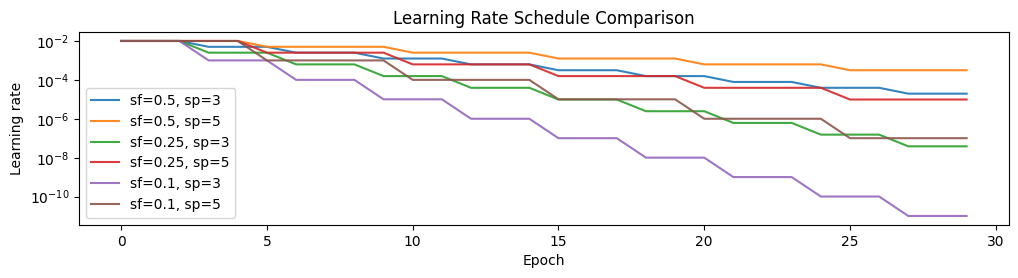

In [33]:
# plotting the learning rate schedule function for various hyperparameter values.
def lr_schedule_function(epoch, initial_lr, scale_factor, lr_scale_patience):
    return initial_lr * lr_scale_factor ** (epoch // lr_scale_patience)

initial_lr = 0.01
lr_scale_factors = [0.5, 0.25, 0.1]
lr_scale_patiences = [3, 5]

plt.figure(figsize=(12,2.5))

# Plot learning rate schedules for each lr_scale_factor and lr_scale_patience
for lr_scale_factor in lr_scale_factors:
    for lr_scale_patience in lr_scale_patiences:
        lr_rates = [lr_schedule_function(epoch, initial_lr, lr_scale_factor, lr_scale_patience) for epoch in range(30)]
        plt.plot(lr_rates, label='sf={}, sp={}'.format(lr_scale_factor, lr_scale_patience), alpha=0.9)

# Add axis labels and legend
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning Rate Schedule Comparison')
plt.yscale('log')
plt.legend()
plt.show()

#### Designing Experiment Pipeline 
This class allows us to more conveniently experiment with a model design for a given set of hyperparameters:
1. The class repeats the steps in previous sections by rebuilding and preprocessing the data for each new experiment.
2. Then the Transformer is fit to the processed data and trained for up to 30 epochs.

In [34]:
from dataclasses import dataclass

@dataclass
class ModelTuningExperiment:
    sequence_length: int
    max_tokens: int 
    batch_size: int
    num_encoder_blocks: int
    num_heads: int
    ff_hidden_units: int
    dropout_rate: float
    d_model: int
    initial_lr: float
    lr_scale_factor: float
    lr_scale_patience: int
    classification_threshold: float
    ####
    fixed_seed: int = 0
    ####
    X_test = None #for later test eval
    y_test = None #for later test eval
    vectorizer: tf.keras.layers.TextVectorization = None
    train_data: tf.data.Dataset = None
    valid_data: tf.data.Dataset = None
    test_data: tf.data.Dataset = None 
    model: tf.keras.Sequential = None 
    history: tf.keras.callbacks.History = None
    ####
    final_val_acc: float = None
    best_val_acc: float = None

        
    def build_raw_datasets(self, X, y):
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=1/6, 
                                                                    random_state=0
                                                                    )
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                          y_train_val, 
                                                          test_size=1/5, 
                                                          random_state=0
                                                          )
        self.X_test = X_test
        self.y_test = y_test
        self.train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        self.valid_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        self.test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        return self
        

    def create_and_adapt_vectorizer(self):
        vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=self.max_tokens,
            output_sequence_length=int(self.sequence_length),
            pad_to_max_tokens=True
        )
        vectorizer.adapt(self.train_data.map(lambda text, label: text))
        self.vectorizer = vectorizer
        return self


    def process_datasets(self):
        '''
        Preprocesses the training, validation and test datasets.
        Applies the provided vectorizer.
        '''
        self.train_data = self.train_data.map(lambda text, label: (self.vectorizer(text), label)
        ).filter(lambda text, label: tf.reduce_all(tf.not_equal(text, 0))
        ).filter(lambda text, label: tf.reduce_all(tf.not_equal(tf.reduce_sum(label), 0))
        ).shuffle(buffer_size=1000
        ).padded_batch(self.batch_size, 
                       drop_remainder=True, 
                       padded_shapes=([self.sequence_length], [20]))
        
        self.valid_data = self.valid_data.map(lambda text, label: (self.vectorizer(text), label)
        ).filter(lambda text, label: tf.reduce_all(tf.not_equal(text, 0))
        ).filter(lambda text, label: tf.reduce_all(tf.not_equal(tf.reduce_sum(label), 0))
        ).padded_batch(self.batch_size, 
                       drop_remainder=True, 
                       padded_shapes=([self.sequence_length], [20]))
        
        self.test_data = self.test_data.map(lambda text, label: (self.vectorizer(text), label)
        ).filter(lambda text, label: tf.reduce_all(tf.not_equal(text, 0))
        ).filter(lambda text, label: tf.reduce_all(tf.not_equal(tf.reduce_sum(label), 0))
        ).padded_batch(self.batch_size, 
                       drop_remainder=True, 
                       padded_shapes=([self.sequence_length], [20]))
        
        return self


    #sequential API
    def build_model(self):
        tf.random.set_seed(self.fixed_seed) # for reproducibility

        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(None,), dtype=tf.int64),
            
            InputEmbedding(input_dim=self.max_tokens,
                           sequence_length=self.sequence_length,
                           d_model=self.d_model),
            
            tf.keras.Sequential(name='StackedEncoderBlocks', 
                layers = [
                    EncoderBlock(num_heads=self.num_heads, 
                                 d_model=self.d_model, 
                                 ff_hidden_units=self.ff_hidden_units,
                                 dropout_rate=self.dropout_rate)
                    for _ in range(self.num_encoder_blocks)
                ]
            ),
            
            tf.keras.layers.GlobalAveragePooling1D(),
            
            tf.keras.Sequential(name='ff_network', layers=[
                tf.keras.layers.Dense(self.ff_hidden_units, activation='relu'),
                tf.keras.layers.Dense(20, activation='sigmoid')
            ])

        ])
        self.model.build(input_shape=(None, self.sequence_length, 1))
        self.model.compile(optimizer='adam',  #rmsprop?
                           loss='binary_crossentropy',
                           metrics=[tf.keras.metrics.BinaryAccuracy(threshold=self.classification_threshold, 
                                                                    name='accuracy')])
        return self

    
    def lr_schedule(self, epoch):
        return self.initial_lr * self.lr_scale_factor ** (epoch // self.lr_scale_patience)
    

    def train_model(self):
        self.history = self.model.fit(x=self.train_data,
                                      epochs=30,
                                      validation_data=self.valid_data,
                                      callbacks=[tf.keras.callbacks.LearningRateScheduler(self.lr_schedule),
                                                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                                  patience=2)])
        self.final_val_acc = self.history.history['val_accuracy'][-1]
        self.best_val_acc = max(self.history.history['val_accuracy'])
        return self

In [35]:
def run_experiment(**kwargs):
    experiment = ModelTuningExperiment(**kwargs)
    experiment.build_raw_datasets(X,y)\
          .create_and_adapt_vectorizer()\
          .process_datasets()\
          .build_model()\
          .train_model()
    return experiment

#### Preparing the Hyperparameter Space

There are many possible hyperparameters that we can search over for this model. The space of hyperparameter values is far too large to search every possible value. An efficient method may be to use Bayesian optimisation with a Gaussian Process prior, but this may costly to implement without the use of additional libraries. 

As such we will conduct three rounds of experiments:
1. In the first round, we will simply perform a random sampling of candidate hyperparameter values to build up a few observations. Once we have these we may be able to use our own intuition to hand-pick suitable values.
2. Once we have hand-picked some hyperparameter values, we will perform a more explicit and thorough grid search over the hyperparameters `ff_hidden_units` and `d_model`.
3. Finally we will fix the hyperparameters and run experiments for varying RNG seeds. This will allow us to determine a good seed value for our weight initialisations.

#### Step 1) Random Search Tuning

In [ ]:
# Search over possible values for prespecified hyperparameter:
hyperparameter_space = {
    'sequence_length': range(20,60),
    'max_tokens': range(1000,21000,1000),
    'batch_size': range(4,256,2),
    'num_encoder_blocks': range(1,5),
    'num_heads': range(3,9),
    'ff_hidden_units': range(16,257,2),
    'dropout_rate': np.linspace(0,.25, 26),
    'd_model': range(16,257,2),
    'initial_lr' : [1e-3],
    'lr_scale_factor' : np.linspace(.05,.15,11),
    'lr_scale_patience': range(3,6),
    'classification_threshold': [0.5],
}

In [ ]:
# there are O(10^13) combinations, unfortunately we don't have a few hundred million years to try them all.
print('total combinations =', np.product(list(map(lambda x: len(x), list(hyperparameter_space.values())))))

In [ ]:
# we can sample 20 combinations randomly to try and select the best model from those
candidate_values = [dict(map(lambda x: (x[0], np.random.choice(x[1])), hyperparameter_space.items())) for _ in range(20)] 

#peek
candidate_values[:2]

In [ ]:
# Running the random search experiments.

experiment_history = []

for i, candidate in enumerate(candidate_values):
    print(f"Starting Experiment {i+1}/{len(candidate_values)}: with params {candidate}")
    experiment = run_experiment(**candidate)
    print(f"Final accuracy {experiment.final_val_acc:.4f} with best {experiment.best_val_acc:.4f}", '\n\n')
    experiment_history.append(experiment)

In [ ]:
sorted_exps = sorted(enumerate(list(map(lambda x: (x.best_val_acc, x.final_val_acc), experiment_history))),
                         key=lambda x: x[1][0],
                         reverse=True)
best_exp = experiment_history[sorted_exps[0][0]]
best_model = best_exp.model

# Based on these experiments we have some intuition about suitable combinations of parameters. 
#  We can now make an informed decision for the next step using grid search.
best_exp

#### Step 2) Grid Search

In [ ]:
hyperparameter_space_2 = {'sequence_length': [50],
                         'max_tokens': [20000], 
                         'batch_size': [82], 
                         'num_encoder_blocks': [1], 
                         'num_heads': [5], 
                         'ff_hidden_units': list(range(32, 257, 32)),
                         'dropout_rate': [0.155], 
                         'd_model': list(range(32, 257, 32)),
                         'initial_lr': [0.001], 
                         'lr_scale_factor': [0.1], 
                         'lr_scale_patience': [6], 
                         'classification_threshold': [0.5],
                        }

from itertools import product 
candidate_values_2 = list(map(lambda x: dict(zip(hyperparameter_space_2.keys(), x)), 
                              (list(product(*hyperparameter_space_2.values())))))

# peek
candidate_values_2[:2]

In [ ]:
# Running the grid search experiments.

experiment_history_2 = []

for i, candidate in enumerate(candidate_values_2):
    print(f"Starting Experiment {i+1}/{len(candidate_values_2)}: with params {candidate}")
    experiment = run_experiment(**candidate)
    print(f"Final accuracy {experiment.final_val_acc:.4f} with best {experiment.best_val_acc:.4f}", '\n\n')
    experiment_history_2.append(experiment)

In [ ]:
sorted_exps_2 = sorted(enumerate(list(map(lambda x: (x.best_val_acc, x.final_val_acc), experiment_history_2))),
                         key=lambda x: x[1][0],
                         reverse=True)
best_exp_2 = experiment_history_2[sorted_exps_2[0][0]]
best_model_2 = best_exp_2.model

# Based on these experiments we have some idea about suitable values for ff_hidden_units and d_model.
best_exp_2

In [ ]:
exp2_results = pd.DataFrame(np.array(list(map(lambda x: (x.ff_hidden_units, x.d_model, x.final_val_acc, x.best_val_acc), experiment_history_2))),
                            columns=['ff_hidden_units', 'd_model', 'final_val_acc', 'best_val_acc'])

pvt = pd.pivot_table(exp2_results, values='final_val_acc', index=['d_model'], columns=['ff_hidden_units']).iloc[::-1]
pvt.index = pvt.index.astype(int)
pvt.columns = pvt.columns.astype(int)

# plot the heatmap 
plt.imshow(pvt, cmap='Reds', interpolation='nearest')
plt.xticks(range(len(pvt.columns)), pvt.columns)
plt.yticks(range(len(pvt.index)), pvt.index)
plt.xlabel('ff_hidden_units')
plt.ylabel('d_model')
plt.title('Final Validation Set Accuracy')
plt.colorbar()
plt.show()

In [ ]:
sorted_exps_2

#### Step 3) Final Hand--Tuning over Weight Initialisations

The random weight initialisations are important and can dramatically affect model training. For this reason it is sensible to initialise the same architecture many times to find a highly performant initialisation.

In [ ]:
hyperparameter_space_3 = {'sequence_length': [50],
                         'max_tokens': [20000], 
                         'batch_size': [82], 
                         'num_encoder_blocks': [1], 
                         'num_heads': [5], 
                         'ff_hidden_units': [128],
                         'dropout_rate': [0.155], 
                         'd_model': [128],
                         'initial_lr': [0.001], 
                         'lr_scale_factor': [0.1], 
                         'lr_scale_patience': [6], 
                         'classification_threshold': [0.5],
                         'fixed_seed': list(range(5))
                        }

candidate_values_3 = list(map(lambda x: dict(zip(hyperparameter_space_3.keys(), x)), 
                              (list(product(*hyperparameter_space_3.values())))))

# peek
candidate_values_3[:2]

In [ ]:
# Running the weight initialisation experiments.

experiment_history_3 = []

for i, candidate in enumerate(candidate_values_3):
    print(f"Starting Experiment {i+1}/{len(candidate_values_3)}: with params {candidate}")
    experiment = run_experiment(**candidate)
    print(f"Final accuracy {experiment.final_val_acc:.4f} with best {experiment.best_val_acc:.4f}", '\n\n')
    experiment_history_3.append(experiment)

In [ ]:
sorted_exps_3 = sorted(enumerate(list(map(lambda x: (x.best_val_acc, x.final_val_acc), experiment_history_3))),
                         key=lambda x: x[1][1],
                         reverse=True)
best_exp_3 = experiment_history_3[sorted_exps_3[0][0]]
best_model_3 = best_exp_3.model

# Final best model
best_exp_3

In [ ]:
sorted_exps_3

In [ ]:
# Plotting the training metrics of the best model
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

axs[0].plot(best_exp_3.history.history['loss'], label='Training Loss')
axs[0].plot(best_exp_3.history.history['val_loss'], label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(best_exp_3.history.history['accuracy'], label='Training Accuracy')
axs[1].plot(best_exp_3.history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].axhline(y=0.9, color='grey', linestyle=':')

# Adjust the spacing between subplots and show the plot
fig.subplots_adjust(hspace=0.2)
plt.show()

In [ ]:
test_eval_of_exp_3_models = list(map(lambda x: x.model.evaluate(x.test_data), experiment_history_3))

In [ ]:
# Create the subplot
fig, ax = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

colors = ['#00CCDD','#00CCDD','#0000FF','#00CCDD','#00CCDD']

for (seed,acc_ts) in (zip(range(5), list(map(lambda x: np.array(x.history.history['val_accuracy']), experiment_history_3)))):
    ax[0].plot(acc_ts, label=seed, color=colors[seed], alpha=0.5 if seed!=2 else 1)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Validation Set Accuracy')

ax[1].set_ylim(0.899,0.905)
ax[1].set_yticks(np.linspace(0.9,0.905,6))
ax[1].set_xticks([0,1,2,3,4])
ax[1].set_xlabel('Random Seed')
ax[1].set_title('Final Test Accuracy')
ax[1].bar(x=range(5), height=np.array(test_eval_of_exp_3_models)[:,1], color=colors)


plt.ylim(0.888,0.9065)
plt.yticks(np.linspace(0.89,0.905,6))
plt.tight_layout()
plt.show()

### 3) Testing

#### Test Set Accuracy and Confusion Matrices 

In [41]:
best_exp_3 = run_experiment(**{
    'sequence_length': 50,
    'max_tokens': 20000, 
    'batch_size': 42, 
    'num_encoder_blocks': 1, 
    'num_heads': 5, 
    'ff_hidden_units': 32,
    'dropout_rate': 0.125, 
    'd_model': 64,
    'initial_lr': 0.001, 
    'lr_scale_factor': 0.1, 
    'lr_scale_patience': 6, 
    'classification_threshold': 0.5
})

Epoch 1/30
327/327 [==============================] - 39s 110ms/step - loss: 0.3062 - accuracy: 0.8883 - val_loss: 0.2973 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 2/30
327/327 [==============================] - 35s 106ms/step - loss: 0.2825 - accuracy: 0.8963 - val_loss: 0.2689 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 3/30
327/327 [==============================] - 32s 97ms/step - loss: 0.2488 - accuracy: 0.9069 - val_loss: 0.2595 - val_accuracy: 0.8997 - lr: 0.0010
Epoch 4/30
327/327 [==============================] - 32s 96ms/step - loss: 0.2090 - accuracy: 0.9211 - val_loss: 0.2601 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 5/30
327/327 [==============================] - 31s 93ms/step - loss: 0.1731 - accuracy: 0.9347 - val_loss: 0.2796 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 6/30
327/327 [==============================] - 31s 93ms/step - loss: 0.1441 - accuracy: 0.9458 - val_loss: 0.3168 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 7/30
327/327 [==============================] - 31

In [42]:
# Evaluating on the entire test set, we see the final cross entropy and accuracy scores. 
#  The model achieves >90% accuracy.

best_exp_3.model.evaluate(best_exp_3.test_data)

82/82 [==============================] - 3s 39ms/step - loss: 0.3313 - accuracy: 0.8970


[0.33133238554000854, 0.8970237970352173]

In [ ]:
# Get the predicted labels for the test data
y_pred = (best_exp_3.model.predict(best_exp_3.test_data) > best_exp_3.classification_threshold).astype(float)

# Get the true labels for the test data
y_true = []
for k, (_, label) in enumerate(best_exp_3.test_data):
    print(k+1, end='\r') # counter
    y_true.append(label.numpy())
y_true = np.array(y_true).reshape(-1,20)

#overall accuracy
print('Final test set accuracy =',np.mean(y_true == y_pred))
# matches the final result above.

In [ ]:
def compute_confusion_matrices(truth: np.ndarray, preds: np.ndarray):
    true_pos = np.logical_and((y_true==1),(y_pred==1)).sum(axis=0)
    true_neg = np.logical_and((y_true==0),(y_pred==0)).sum(axis=0)
    false_pos = np.logical_and((y_true==0),(y_pred==1)).sum(axis=0)
    false_neg = np.logical_and((y_true==1),(y_pred==0)).sum(axis=0)
    
    cm = {}
    for col,genre in enumerate(y_label_encoder.classes_):
        cm[genre] = np.array([[true_pos[col],false_pos[col]],[false_neg[col],true_neg[col]]]).astype(int)
    return(cm)

In [ ]:
# Create the confusion matrix for each label
class_names = list(y_label_encoder.classes_)
cm = compute_confusion_matrices(y_true, y_pred)

# normalised_cm = {k: v/y_pred.shape[0] for k,v in cm.items()}

In [ ]:
# Plotting the confusion matrices for each label as a 2x10 grid.
num_rows = 2
num_cols = 10

# Create a new figure and set its size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 6), sharey=True, sharex=True)
plt.subplots_adjust(wspace=.1, hspace= -.55)

axs = axs.ravel()
n_obs = y_true.sum(axis=0).astype(int) # number of each label observed

# Loop through each genre and plot its confusion matrix in a separate subplot
for i, (genre, cmatrix) in enumerate(cm.items()):
    ax = axs[i]
    im = ax.imshow(cmatrix, interpolation='nearest', vmin=1, vmax=y_pred.shape[0], cmap='autumn', norm='log')
    ax.set_title(f"{genre} ({n_obs[i]})", size=8)
    
#     fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04, )
    
    if i > 9:
        ax.set_xlabel('Truth')
    if i%num_cols==0:
        ax.set_ylabel('Preds')

    ax.set_xticks([])
    ax.set_yticks([])
            
    # Add text labels for each cell in the confusion matrix
    for j in range(2):
        for k in range(2):
            text = ax.text(k, j, format(cmatrix[j][k], '.0f'),
                           ha="center", va="center", color="black" )

plt.show()

In [ ]:
# precision, recall and F1 scores.

prec_rec_f_scores = np.zeros((20,3))

# Precision and Recall Metrics
for j, (genre,cmatrix) in enumerate(cm.items()):
    genre_tp = cmatrix[0,0]
    genre_fp = cmatrix[0,1]
    genre_fn = cmatrix[1,0]
    genre_tn = cmatrix[1,1]
    genre_recall = genre_tp / (genre_tp+genre_fp)
    genre_precision = genre_tp / (genre_tp+genre_fn)
    genre_f1 = genre_tp/(genre_tp+0.5*(genre_fp+genre_fn))

    prec_rec_f_scores[j,0] = genre_precision
    prec_rec_f_scores[j,1] = genre_recall
    prec_rec_f_scores[j,2] = genre_f1

prec_rec_f_scores = pd.DataFrame(prec_rec_f_scores, 
                                 columns=['Precision','Recall','F1_Score'],
                                 index=cm.keys())

prec_rec_f_scores = prec_rec_f_scores.fillna(0)
prec_rec_f_scores

In [ ]:
# plotting precision, recall, f1

plt.figure(figsize=(15,3))
plt.imshow(prec_rec_f_scores.T, vmin=0, vmax=prec_rec_f_scores.max().max(), cmap='coolwarm')
plt.colorbar(fraction=.00735, pad=0.01)
plt.xticks(range(len(prec_rec_f_scores.index)), prec_rec_f_scores.index, rotation=45, size=12)
plt.yticks(range(3), prec_rec_f_scores.columns, size=15)

# Add text labels to the heatmap
for i in range(len(prec_rec_f_scores.columns)):
    for j in range(len(prec_rec_f_scores.index)):
        text = "{:.2f}".format(prec_rec_f_scores.iloc[j, i])
        plt.text(j, i, text, ha="center", va="center", color="black", fontsize=12)

plt.show()

#### Testing the Model with Input Strings

In [44]:
# Test Predictions on Fabricated Examples. Test your own by adding a string to the list!

descriptions = [
               "A team of scientists unlock the secrets of teleportation and unleash an infinite universe of possibilities. Now they must face an unprecedented threat in a race against time to save humanity from catastrophe.",
               "A young musician overcomes devastating adversity and finds love in this tragic coming-of-age story.",
               "Experience the brutal intensity of D-Day 1945 like never before, as recolored footage offers a unique perspective of the heroic soldiers storming the beaches of Normandy and changing the course of history.",
               "Bullets fly and the streets erupt in a symphony of chaos as an FBI agent, framed for a crime she didn't commit, fights tooth and nail to clear her name and take down those who betrayed her.",
               "Get ready for a night of non-stop chuckles as three bumbling clowns unwittingly find themselves center stage in a circus act, causing chaos and hilarity to ensue at every turn!",
               "Embark on a fascinating journey into the hidden world of nocturnal mammals, as this captivating nature programme delves deep into their unique life cycle, behaviors, and survival strategies under the veil of darkness.",
               "Join a mischievous group of kids on an enchanted quest through a mystical realm, as they rally together to thwart the evil wizards and rescue the elf kingdom.",
               "Amid the ruins of a once-thriving city, a lone survivor must navigate a harrowing, post-apocalyptic wasteland plagued by a deadly virus and the worst of human nature, in a desperate struggle to survive.",
               "A robot assassin from a dystopian future is sent back in time to kill the leader of the human resistance.",
               ]

def get_genre_predictions(experiment, descriptions):
    for description in descriptions:
        preds = np.array(experiment.model(experiment.vectorizer([description])).numpy()[0])
        pred_idx = np.where(preds>experiment.classification_threshold)[0]
        labels = list(zip(y_label_encoder.classes_[pred_idx], preds[pred_idx]))
        if not labels: # if none over threshold, then just get the single highest prob label.
            labels = [(y_label_encoder.classes_[np.argmax(preds)], preds[np.argmax(preds)])]

        print('\n',f'description={description}', '\n\n', 'prediction=',sorted(labels, key=lambda x: x[1], reverse=True), '\n')

get_genre_predictions(experiment=best_exp_3, descriptions=descriptions)


 description=A team of scientists unlock the secrets of teleportation and unleash an infinite universe of possibilities. Now they must face an unprecedented threat in a race against time to save humanity from catastrophe. 

 prediction= [('Science Fiction', 0.8656564), ('Horror', 0.8008931)] 


 description=A young musician overcomes devastating adversity and finds love in this tragic coming-of-age story. 

 prediction= [('Drama', 0.883851), ('Romance', 0.671309), ('Comedy', 0.6181978)] 


 description=Experience the brutal intensity of D-Day 1945 like never before, as recolored footage offers a unique perspective of the heroic soldiers storming the beaches of Normandy and changing the course of history. 

 prediction= [('Drama', 0.99652994), ('History', 0.6154939), ('War', 0.60462)] 


 description=Bullets fly and the streets erupt in a symphony of chaos as an FBI agent, framed for a crime she didn't commit, fights tooth and nail to clear her name and take down those who betrayed her

In [ ]:
# Peek at some of the real test data from the Kaggle dataset. 

for j in range(20):
    get_genre_predictions(experiment = best_exp_3, descriptions = [best_exp_3.X_test.iloc[j]])
    print('true_label=',y_label_encoder.classes_[np.where(best_exp_3.y_test[j])[0]],'\n')